### main (Data import / Global variables / Parameters...)

In [3]:
import scipy.io
ratdata = scipy.io.loadmat('chrono_B069_rawdata.mat')

In [4]:
import numpy as np

In [5]:
# trial index starts from 0 

def trialdata(ratdata,trial):
    if ratdata['rawdata']['pokedR'][0][trial] > 0 :
        rat_choice = "R"
    else : 
        rat_choice = "L"
        
    return ratdata['rawdata']['rightbups'][0][trial][0], \
ratdata['rawdata']['leftbups'][0][trial][0], \
ratdata['rawdata']['T'][0][trial], rat_choice

In [6]:
# trial index starts from 0 
RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 0) 
print LeftClickTimes
print rat_choice

[ 0.       0.19235  0.34361]
L


In [7]:
# Global variables 
epsilon = 10.0**(-10) 
dx = 0.25 
dt = 0.02
Nsteps = int(np.ceil(1.0/dt))

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

## function bin_centers = make_bins(B, dx, binN)

In [8]:
import numpy as np

def make_bins(B, dx, binN):
    bins = (np.arange(binN)+1)*B
    bins = dx*bins/B
    
    if bins[-1] == B:
        bins[-1] = B+dx
    else:
        bins[-1] = 2*B - bins[-2]
    
    bins = np.hstack((-bins[::-1], np.array([0]), bins))
    return bins

In [9]:
B = 4.1
dx = 0.25
binN = np.ceil(B/dx)

bin_centers = make_bins(B,dx,binN)
print bin_centers
print binN

[-4.2  -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5
 -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5
  1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75  4.    4.2 ]
17.0


## function F = Fmatrix([sigma, lambda, c], bin_centers)

In [34]:
import numpy as np

def Fmatrix(params, bin_centers):
    global dt,dx
    sigma2 = params[0]
    lam = params[1]
    c = params[2]
    
    sigma2_sbin = sigma2
    
    F = np.zeros((bin_centers.size,bin_centers.size))
    
    if lam == 0:  # for Fi
        mus = bin_centers*np.exp(lam*dt)
    else:        
        mus = np.exp(lam*dt)*(bin_centers + c/lam) - c/lam

        
# modified it according to gaussbins.m -amyoon
#     sbinsize = 0.1*sigma_sbin
#     swidth = 4*sigma_sbin
#     sbins = np.arange(-swidth,swidth+epsilon,sbinsize)
    n_sbins = max(70, np.ceil(10*np.sqrt(sigma2_sbin)/dx))

    swidth = 5*np.sqrt(sigma2_sbin)
    sbins = np.linspace(-swidth,swidth,n_sbins*2+1)
    sbinsize = sbins[1]-sbins[0]
    
    ps = np.exp(-sbins**2/(2*sigma2)) 
    ps = ps/sum(ps)
            
    base_sbins = sbins
    
        
    for j in np.arange(bin_centers.size-1)+1:
        sbins = base_sbins + mus[j]
        tmp = 1
        
        for k in range(sbins.size):
            if sbins[k] <= bin_centers[0]:
                F[0,j] += ps[k]
            elif sbins[k] >= bin_centers[-1]:
                F[-1,j] += ps[k]
            else:
                if (sbins[k] > bin_centers[0] and sbins[k] < bin_centers[1]):
                    bottom = 0; top = 1;
                elif (sbins[k] > bin_centers[-2] and sbins[k] < bin_centers[-1]):
                    bottom = bin_centers.size-2; top = bin_centers.size-1;
                else :    
                    bottom = int(np.floor((sbins[k]-bin_centers[1])/dx) + 1);
                    top = int(np.ceil((sbins[k]-bin_centers[1])/dx) + 1);

                if bottom < 0: bottom = 0; 
                if top < 0: top = 0; 

                if bottom == top:
                    F[bottom,j] += ps[k]
                else:
                    F[top,j] += ps[k]*(sbins[k] - bin_centers[bottom])/(bin_centers[top] - bin_centers[bottom])
                    F[bottom,j] += ps[k]*(bin_centers[top] - sbins[k])/(bin_centers[top] - bin_centers[bottom])
                     
    F[:,0] = 0
    F[:,-1] = 0
    F[0,0] = 1
    F[-1,-1] = 1
    
    return F

In [35]:
F = Fmatrix([0.2, 0, 0.0],bin_centers) # Fi
F

array([[ 1.        ,  0.41181999,  0.21890701, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.19714171,  0.17213129, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.18722765,  0.21792338, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.21792338,
         0.18722765,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.17213129,
         0.19714171,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.21890701,
         0.41181999,  1.        ]])

In [36]:
F = Fmatrix(params,bin_centers)
F

array([[ 1.        ,  0.46112513,  0.36500678, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.09084516,  0.08595918, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.09459485,  0.10083522, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.09992243,
         0.09525969,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0863713 ,
         0.09014276,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.36821346,
         0.46453357,  1.        ]])

## function logProbRight(params)
#### params = [sigma_a, sigma_s, sigma_i, lambda, B, bias, phi, tau_phi, lapse

In [42]:
# Nsteps : number of time steps

# RightClicksTimes : times of right clicks
# LeftClicksTimes : tiems of left clicks

# RightClicks : adapted weights of right clicks
# LeftClicks : adapted weights of left clicks

# NClicks : number of clicks for all time steps


def logProbRight(params):
    """
    :params : arrays of parameters
    : sigma2_a
    : sigma2_s
    : sigma2_i
    : lam 
    : B
    : bias
    : phi
    : tau_phi
    : lapse
    """

    sigma2_a = params[0]
    sigma2_s = params[1]
    sigma2_i = params[2]
    lam = params[3]
    B = params[4]
    bias = params[5]
    phi = params[6]
    tau_phi = params[7]
    lapse = params[8]
    
    global a, dx, dt, maxT, Nsteps, rat_choice, LeftClickTimes, RightClickTimes, a_trace, c_trace, bin_centers
    
    Nsteps = int(np.ceil(maxT/dt))

    if RightClickTimes.size == 0:
        RightClickTimes = np.empty(0)
    if LeftClickTimes.size == 0:
        LeftClickTimes = np.empty(0)
    
    net_input = np.zeros((1, Nsteps))
    total_input = np.zeros((1, Nsteps))

    NClicks = np.zeros((1, Nsteps))    
    
        
    # ====== Make adapted clicks
    
    Lsame = np.ones((1,np.size(LeftClickTimes)))
    Rsame = np.ones((1,np.size(RightClickTimes)))
    # magnitude of stereo clicks set to zero   
    Lsame[0] = 0; Rsame[0] = 0;
    
    # inter-click-intervals
    ici_L = np.diff(LeftClickTimes)
    ici_R = np.diff(RightClickTimes)
    
    for i in np.arange(np.size(LeftClickTimes)-1)+1:
        last_L = tau_phi*np.log(1-Lsame[0][i-1]*phi)
        Lsame[0][i] = 1 - np.exp((-ici_L[i-1] + last_L)/tau_phi)
        
    for i in np.arange(np.size(RightClickTimes)-1)+1:
        last_R = tau_phi*np.log(1-Rsame[0][i-1]*phi)
        Rsame[0][i] = 1 - np.exp((-ici_R[i-1] + last_R)/tau_phi)

    Lsame = Lsame.real    
    Rsame = Rsame.real   
        
    # index starts from 0
    # net_input / total_input
    # Counting number of clicks
    cnt = 0
    for i in np.ceil((RightClickTimes+epsilon)/dt).astype(int):
        NClicks[0][i-1] += 1
        net_input[0][i-1] += Rsame[0][cnt]
        total_input[0][i-1] += Rsame[0][cnt]
        cnt += 1
    
    cnt = 0 
    for i in np.ceil((LeftClickTimes+epsilon)/dt).astype(int):
        NClicks[0][i-1] += 1  
        net_input[0][i-1] -= Lsame[0][cnt]
        total_input[0][i-1] += Lsame[0][cnt]
        cnt += 1        
       
    
    print net_input
    print total_input
    
    binN = int(np.ceil(B/dx))
    
    bin_centers = make_bins(B,dx,binN)
        
    a_trace = np.zeros((bin_centers.size, Nsteps))
    c_trace = np.zeros((1, Nsteps+1))
    a0 = np.zeros(bin_centers.size)
    a0[binN] = 1-2*lapse; a0[0] = lapse; a0[-1] = lapse;

    
    Fi = Fmatrix([sigma2_i, 0, 0.0], bin_centers)
    
    a = np.matmul(Fi,a0)
    a_trace[:,0] = a.flatten()
 
    F0 = Fmatrix([sigma2_a*dt, lam, 0.0], bin_centers)
    for i in np.arange(Nsteps-1)+1:
        if total_input[0][i-1]==0:
            a = np.matmul(F0,a)
        else:
            total_var = sigma2_a*dt + (sigma2_s*total_input[0][i-1])/40
            F = Fmatrix([total_var, lam, net_input[0][i-1]/dt], bin_centers)
            a = np.matmul(F,a)
            
        c_trace[0][i] = net_input[0][i-1]
        a_trace[:,i] = a.flatten()

    bias_bottom = int(np.floor((bias-bin_centers[1])/dx) + 1)
    bias_top = int(np.ceil((bias-bin_centers[1])/dx) + 1) # top
    print(bias_bottom)
    
    Pd = np.zeros((1, bin_centers.size))
    Pd[0][-bias_top+1:] = a[-bias_top+1:]
    if bias_bottom == bias_top:
        Pd[0][bias_bottom] = a[bias_bottom]/2
    else:
        dh = bin_centers[bias_top] - bias
        dl = bias - bin_centers[bias_bottom]
        dd = dh + dl
        Pd[0][bias_top] = a[bias_top]*(0.5 + dh/dd/2)
        Pd[0][bias_bottom] = a[bias_bottom]*(dh/dd/2)
    
    pright = sum(Pd[0])
    
    return np.log(pright)

In [43]:
np.sum(a_trace,axis = 0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

In [44]:
def logLike(params):
    global rat_choice
    if rat_choice == "R":
        LP_right = logProbRight(params)
#         print "R : " + str(LP_right)
        return LP_right
    elif rat_choice == "L":
        LP_right = logProbRight(params)
#         print "L : " + str(np.log(1 - np.exp(LP_right)))
        return np.log(1 - np.exp(LP_right))
    else:
        print "Rat did what?? It was neither R nor L"

In [45]:
logLike(params)

[[ 0.21174577  0.          0.          0.          0.          0.59572769
   0.          0.          0.         -0.85390527  0.68879055  0.          0.
   0.          0.          0.          1.0679164  -0.83610755]]
[[ 0.21174577  0.          0.          0.          0.          0.59572769
   0.          0.          0.          0.85390527  0.68879055  0.          0.
   0.          0.          0.          1.0679164   0.83610755]]
17


-2.5352539404380012

In [40]:
def llikey(params, rat_choice, maxT=1, RightPulseTimes=np.array([]), LeftPulseTimes=np.array([])):

    global RightClickTimes, LeftClickTimes, Nsteps
        
    RightClickTimes = RightPulseTimes.compress((RightPulseTimes <= maxT).flat)
    LeftClickTimes  = LeftPulseTimes.compress((LeftPulseTimes <= maxT).flat)
    Nsteps = int(np.ceil(maxT/dt))
    
    B = params[4]
    binN = int(np.ceil(B/dx))
    bin_centers = make_bins(B, dx, binN); 
    bin_times = dt*np.arange(Nsteps+1);
             
    LL = logLike(params)
    
#     print LL
#     LLgrad = tf.gradients(LL, params)[0]
#     hess = tf.map_fn(lambda grid: tf.gradients(grad,))
    
    return LL

In [36]:
LL = llikey(params, "R", RightPulseTimes=np.array([0.2, 0.4]))
LL

21


-0.77424568532002769

In [46]:
### =============== testing 1 ================= ####

# Global variables 
epsilon = 10.0**(-10) 
dx = 0.25
dt = 0.02

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

# trial index starts from 0 
RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 0) 

Nsteps = int(np.ceil(maxT/dt))

logLike(params)

### =========================================== ####

[[ 0.21174577  0.          0.          0.          0.          0.59572769
   0.          0.          0.         -0.85390527  0.68879055  0.          0.
   0.          0.          0.          1.0679164  -0.83610755]]
[[ 0.21174577  0.          0.          0.          0.          0.59572769
   0.          0.          0.          0.85390527  0.68879055  0.          0.
   0.          0.          0.          1.0679164   0.83610755]]
17


-2.5352539404380012

In [20]:
np.arange(np.size(LeftClickTimes)-1)+1

array([1, 2])

In [ ]:
np.ceil((RightClickTimes+epsilon)/dt).astype(int)

print a_trace[:,1]

In [ ]:
sum(a_trace[:,1])

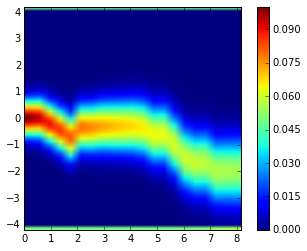

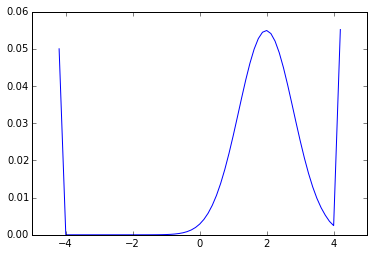

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, 9) 

LL = logProbRight(params)

plt.imshow(a_trace)
im = plt.imshow(a_trace)
plt.colorbar()
im.set_extent([0,maxT*20,bin_centers[0], bin_centers[-1]])
plt.show()

plt.plot(bin_centers,a)

In [46]:
import matplotlib.pyplot as plt
%matplotlib auto

dt = 0.02

for i in range(27):
    RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, i) 

    LL = logProbRight(params)

    plt.subplot(3,9,i+1)
    plt.imshow(a_trace)
    plt.title('trial'+str(i+1))
#     plt.colorbar()
#     plt.show()

Using matplotlib backend: MacOSX


## function multiLL(ratdata, params, Ntrials)

In [34]:
def multiLL(ratdata, params, ntrials):
    global RightClickTimes, LeftClickTimes, maxT, rat_choice
    LL = 0
    LLgrad = np.zeros((np.shape(params)[0]))
    LLhessian = np.zeros((np.shape(params)[0],np.shape(params)[0]))
    
    for i in range(ntrials):
        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, i)
#         LLi = llikey(params, rat_choice, maxT=maxT, RightPulseTimes=RClickTimes, LeftPulseTimes = LClickTimes)
        LLi = logLike(params)
    
        LL        = LL + LLi;
#         LLgrad    = LLgrad + LLgradi;
#         LLhessian = LLhessian + LLhessiani;

        print(str(i+1)+ " - LL : " + str(LLi))
        
    return LL, LLgrad, LLhessian

In [39]:
epsilon = 10.0**(-10); dx = 0.25; dt = 0.02; 
# Nsteps = int(np.ceil(1.0/dt))

sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

multiLL(ratdata, params, 27)

1 - LL : -2.53525394044
2 - LL : -0.24006876781
3 - LL : -0.0531116119157
4 - LL : -2.83579157905
5 - LL : -0.186951988171
6 - LL : -1.2005228119
7 - LL : -0.0512972358983
8 - LL : -0.0513274576985
9 - LL : -1.48963010726
10 - LL : -0.0713736489741
11 - LL : -0.979718818874
12 - LL : -0.0515012017268
13 - LL : -0.244442000025
14 - LL : -2.94919169312
15 - LL : -0.542772758795
16 - LL : -0.0513611903012
17 - LL : -0.0532302874616
18 - LL : -1.01690614149
19 - LL : -0.0520756616866
20 - LL : -0.162860506091
21 - LL : -0.0532741659969
22 - LL : -2.99530324693
23 - LL : -0.797323780376
24 - LL : -1.394077005
25 - LL : -0.0671278829042
26 - LL : -0.0512951210374
27 - LL : -0.0945154950112


(-20.272306105945415,
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

### Applying tensorflow

In [41]:
import tensorflow as tf
# data = tf.placeholder(tf.float32)
# var = tf.Variable()
# loss = func(var, data)

tf_params = tf.Variable(params, name = "params")
loss = logLike(W)

var_grad = tf.gradients(loss, tf_params)[0]

sess = tf.Session()

var_grad_val = sess.run(var_grad, feed_dict = {data: ...})

SyntaxError: invalid syntax (<ipython-input-41-8f423c542ced>, line 13)

In [ ]:
import tensorflow as tf

tf_params = tf.Variable(params, name = "params")
loss = logLike(tf_params)

opt = tf.train.AdamOptimizer(0.1)
grads = opt.compute_gradients(loss)

grad_placeholder = [tf.float32]
apply_placeholder_op = opt.apply_gradients(grad_placeholder)
transform_grads = [(function1(grad[0]), grad[1]) for grad in grads]
apply_transform_op = opt.apply_gradients(transform_grads)

# Initialize
sess = tf.Session()
sess.run(tf.initialize_all_variables())
                     
grad_vals = sess.run([grad[0] for grad in grads])